# Regression Analysis
## Model
$$ Supply: P = aQ + sigma $$
$$ Demand: P = aQ + b*Income + c*subscriptionRate + d*Households + e*Business + Race + Age + Borough + sigma $$
$$ P = aQ + bIncome + c*subscriptionRate + d*Households + e*Business + Race + Age + Borough + sigma $$

In [2]:
import pandas as pd
import numpy as np

In [3]:
# import data about number of households and business account
plan_adoption_nta_data_path = "data/Internet_Master_Plan__Adoption_and_Infrastructure_Data_by_Neighborhood.csv"
adoption_table = pd.read_csv(plan_adoption_nta_data_path)
target_var = ['Neighborhood Tabulation Area Code (NTA Code)', 
               'Total Number of Households', 'Estimated Number of Businesses']
adoption = adoption_table.loc[:,target_var].fillna(0)
adoption = adoption.rename(columns={'Neighborhood Tabulation Area Code (NTA Code)' : 'Neighborhood Tabulation Area (NTA)'})

households = []
for j in range(len(adoption)):
    if isinstance(adoption.loc[j,'Total Number of Households'],str) and len(adoption.loc[j,'Total Number of Households'])>=5:
        first = adoption.loc[j,'Total Number of Households'].split(',')[0]
        last = adoption.loc[j,'Total Number of Households'].split(',')[1]
        households.append(1000*int(first)+int(last))
    else:
        households.append(int(adoption.loc[j,'Total Number of Households']))
adoption['Num_households'] = np.array(households)

business = []
for j in range(len(adoption)):
    if isinstance(adoption.loc[j,'Estimated Number of Businesses'],str) and len(adoption.loc[j,'Estimated Number of Businesses'])>=5:
        first = adoption.loc[j,'Estimated Number of Businesses'].split(',')[0]
        last = adoption.loc[j,'Estimated Number of Businesses'].split(',')[1]
        business.append(1000*int(first)+int(last))
    else:
        business.append(int(adoption.loc[j,'Estimated Number of Businesses']))
adoption['Num_business'] = np.array(business)

adoption = adoption.drop(columns=['Total Number of Households','Estimated Number of Businesses'])
adoption.head()

,Neighborhood Tabulation Area (NTA),Num_households,Num_business
0,BK09,11115,3097
1,BK17,26150,2474
2,BK19,14557,2651
3,BK21,11236,771
4,BK23,8401,719


In [4]:
# import census_NTA_equivalence table
# downloaded from https://www1.nyc.gov/site/planning/data-maps/nyc-population/geographic-reference.page
tract_nta = pd.read_excel('data/NTAs/NTA_tract_equivalence.xlsx')
tract_nta['tract'] = tract_nta['tract'].astype(str)
BoroCTLbl = []
for i in range(len(tract_nta)):
    first = tract_nta.loc[i,'tract'].split('.')[0]
    last = tract_nta.loc[i,'tract'].split('.')[1]
    if last == '0':
        BoroCTLbl.append(str(tract_nta.loc[i,'Borough']+' '+first))
    else:
        BoroCTLbl.append(str(tract_nta.loc[i,'Borough']+' '+tract_nta.loc[i,'tract']))
tract_nta['BoroCTLbl'] = np.array(BoroCTLbl)
tract_nta = tract_nta[['Neighborhood Tabulation Area (NTA)','BoroCTLbl']]
tract_nta.head(10)

,Neighborhood Tabulation Area (NTA),BoroCTLbl
0,BX98,Bronx 1
1,BK09,Brooklyn 1
2,MN99,Manhattan 1
3,QN31,Queens 1
4,BX09,Bronx 2
5,BK32,Brooklyn 2
6,QN53,Queens 2
7,MN28,Manhattan 2.01
8,MN28,Manhattan 2.02
9,SI22,Staten Island 3


In [5]:
# import Income data in percentage
income = pd.read_csv('data/Demographics/Income/household_income_acs2018.csv')
income = income.sort_values(by='tract')
income = income.drop(columns=['city','tract','Households (HH) Count','Household Median Income','Household Mean Income'])
income.columns = income.columns.str.replace('HH ', '')
income['BoroCTLbl'] = income['BoroCTLbl'].astype(str)
income.head()

,county,BoroCTLbl,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,k150_k200,k200_UP
0,Bronx,Bronx 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1100,Manhattan,Manhattan 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1388,Queens,Queens 1,4.9,0.3,2.5,2.2,2.6,8.2,10.5,20.9,15.8,32.2
339,Brooklyn,Brooklyn 1,3.2,2.2,9.4,2.7,5.0,14.0,19.3,9.8,13.9,20.5
340,Brooklyn,Brooklyn 2,11.6,5.3,6.1,23.8,10.8,21.1,6.4,8.6,1.1,5.3


In [6]:
# Race data in percentage
race = pd.read_csv('data/Demographics/Basic Count/tract_race_acs2018.csv')
race = race.assign(White = lambda x: x["White"]/x["Total"]*100,
                  Black = lambda x: x["Black"]/x["Total"]*100,
                  Native = lambda x: x["Native"]/x["Total"]*100,
                  Asian = lambda x: x["Asian"]/x["Total"]*100,
                  PacificIslander = lambda x: x["Pacific_Islander"]/x["Total"]*100,
                  Other = lambda x: x["Other"]/x["Total"]*100,
                  TwoOrMore = lambda x: x["Two or More"]/x["Total"]*100)
race = race.fillna(0)
race = race.drop(columns=['city','county','Total','Two or More','Pacific_Islander']).sort_values(by='tract')
race['BoroCTLbl'] = race['BoroCTLbl'].astype(str)
race.head()

,tract,BoroCTLbl,White,Black,Native,Asian,Other,PacificIslander,TwoOrMore
23,1.0,Bronx 1,25.042373,59.872881,0.353107,1.765537,12.005650,0.0,0.960452
907,1.0,Brooklyn 1,65.280572,15.157612,0.715404,8.920188,5.902079,0.0,4.024145
1225,1.0,Manhattan 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1742,1.0,Queens 1,64.054360,5.594564,0.000000,22.808607,2.061155,0.0,5.481314
590,2.0,Brooklyn 2,45.132743,3.861625,0.000000,4.987932,41.029767,0.0,4.987932


In [7]:
# Age data
age = pd.read_csv('data/Demographics/Age_Sex/tract_age_sex_acs2018.csv')
age = age.sort_values(by='tract')
age = age.drop(columns=['Male','Female'])
for i in range(5,len(age.columns)):
    age.iloc[:,i] = age.iloc[:,i]/age.loc[:,'Total']*100
age = age.fillna(0)
age = age.drop(columns=['tract','county','city','Total'])
age['BoroCTLbl'] = age['BoroCTLbl'].astype(str)
age.head()

,BoroCTLbl,A00_A05,A05_A09,A10_A14,A15_A19,A20_A24,A25_A29,A30_A34,A35_A39,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
0,Bronx 1,0.000000,0.000000,0.000000,7.641243,15.805085,14.449153,14.731638,13.516949,9.957627,8.375706,8.629944,4.788136,1.384181,0.720339,0.000000,0.000000,0.000000,0.000000
1100,Manhattan 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1388,Queens 1,10.192525,4.903737,1.155153,0.826727,2.740657,14.530011,20.928652,13.091733,9.331823,8.505096,4.043035,3.816535,2.627407,0.486976,1.778029,1.041903,0.000000,0.000000
339,Brooklyn 1,4.560698,4.381847,2.638051,3.822938,1.922647,7.467024,7.780013,8.562486,8.338922,11.133467,6.751621,5.097250,7.802370,9.300246,3.241672,3.264029,0.804829,3.129890
340,Brooklyn 2,3.459372,8.286404,8.688656,5.390185,8.769107,12.228479,11.263073,5.390185,6.436042,9.654063,6.275141,4.666130,0.884956,3.459372,1.126307,1.287208,1.528560,1.206758


In [8]:
# Borough data
borough = income.iloc[:,:2]
borough_name = ['Bronx','Brooklyn','Queens','Manhattan','Staten Island']
for i in borough_name:
    borough[i] = 0
for i in range(len(borough)):
    boro = borough.loc[i,'county']
    borough.loc[i,boro] = 1
borough = borough.drop(columns=['county'])
borough['BoroCTLbl'] = borough['BoroCTLbl'].astype(str)
borough.columns = borough.columns.str.replace('Staten Island', 'Staten_Island')
borough.head() 

,BoroCTLbl,Bronx,Brooklyn,Queens,Manhattan,Staten_Island
0,Bronx 1,1,0,0,0,0
1100,Manhattan 1,0,0,0,1,0
1388,Queens 1,0,0,1,0,0
339,Brooklyn 1,0,1,0,0,0
340,Brooklyn 2,0,1,0,0,0


In [9]:
# broadband price data
broadband_ISP_merged = pd.read_csv('data/Broadband Prices/broadband_price_census2018.csv')
broadband_ISP_merged_concise = broadband_ISP_merged.drop(columns=['boro','providers','ctlabel'])
broadband_ISP_merged_concise['BoroCTLbl'] = broadband_ISP_merged_concise['BoroCTLbl'].astype(str)
broadband_ISP_merged_concise.head()
broadband_ISP_merged_concise.head()

,BoroCTLbl,num_providers,price
0,Bronx 1,3.0,53.326667
1,Bronx 2,4.0,68.747500
2,Bronx 4,4.0,68.747500
3,Bronx 16,4.0,68.747500
4,Bronx 19,4.0,68.747500


In [10]:
# load subscription dataset and transfrom values to percentage
subscription = pd.read_csv("data/ACS_Internet_Subscription/subscription_acs_2018.csv")
subscription = subscription.assign(Mobile_Dependent = lambda x: x["Mobile_Dependent"]/x["Total"]*100,
                                   Wired_Broadband = lambda x: x["Wired_Broadband"]/x["Total"]*100,
                                   No_Internet = lambda x: x["No_Internet"]/x["Total"]*100)
subscription = subscription.drop(columns=['city','tract','county','Total'])
subscription.head()

,BoroCTLbl,Mobile_Dependent,Wired_Broadband,No_Internet
0,Bronx 429.02,9.005629,62.664165,26.203877
1,Bronx 330,4.227337,69.375294,19.116956
2,Bronx 358,8.186656,71.428571,10.028653
3,Bronx 371,5.405405,53.306498,36.112708
4,Bronx 385,9.378734,52.568698,28.076464


In [11]:
# merge data and get log value
pqi = broadband_ISP_merged_concise.merge(income, on='BoroCTLbl')
pqir = pqi.merge(race, on='BoroCTLbl')
pqirb = pqir.merge(borough, on='BoroCTLbl')
pqirba = pqirb.merge(subscription, on='BoroCTLbl')
dataset = pqirba.merge(age, on='BoroCTLbl')
dataset.head()

,BoroCTLbl,num_providers,price,county,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
0,Bronx 1,3.0,53.326667,Bronx,0.0,0.0,0.0,0.0,0.0,0.0,...,9.957627,8.375706,8.629944,4.788136,1.384181,0.720339,0.000000,0.000000,0.000000,0.000000
1,Bronx 2,4.0,68.747500,Bronx,6.9,2.4,12.3,9.9,11.5,20.4,...,6.186702,8.080141,9.335095,3.478644,5.394100,7.243505,8.564509,2.091590,0.638485,2.377807
2,Bronx 4,4.0,68.747500,Bronx,7.2,1.9,7.6,3.5,8.5,18.0,...,6.886759,9.424920,7.241747,9.034434,5.378062,4.419595,3.727370,1.508697,1.384452,1.561945
3,Bronx 16,4.0,68.747500,Bronx,8.4,12.5,11.8,16.5,15.1,17.8,...,6.641879,6.084164,6.844685,6.540477,4.833531,3.735001,3.515295,4.613825,3.008281,1.842150
4,Bronx 19,4.0,68.747500,Bronx,13.7,10.3,6.7,7.2,18.2,19.3,...,6.907776,5.424955,5.858951,6.473779,2.820976,1.410488,0.289331,0.506329,0.542495,0.000000


In [12]:
dataset_nta = tract_nta.merge(dataset,on='BoroCTLbl')
dataset_nta = dataset_nta.drop(columns=['BoroCTLbl','county','tract']).fillna(0)
dataset_nta.head()

,Neighborhood Tabulation Area (NTA),num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
0,BX98,3.0,53.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.957627,8.375706,8.629944,4.788136,1.384181,0.720339,0.000000,0.000000,0.000000,0.000000
1,BK09,6.0,72.198000,3.2,2.2,9.4,2.7,5.0,14.0,19.3,...,8.338922,11.133467,6.751621,5.097250,7.802370,9.300246,3.241672,3.264029,0.804829,3.129890
2,MN99,3.0,59.995000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,QN31,6.0,67.696000,4.9,0.3,2.5,2.2,2.6,8.2,10.5,...,9.331823,8.505096,4.043035,3.816535,2.627407,0.486976,1.778029,1.041903,0.000000,0.000000
4,BX09,4.0,68.747500,6.9,2.4,12.3,9.9,11.5,20.4,9.5,...,6.186702,8.080141,9.335095,3.478644,5.394100,7.243505,8.564509,2.091590,0.638485,2.377807


In [13]:
dataset_nta_agg = dataset_nta.groupby('Neighborhood Tabulation Area (NTA)').agg(np.mean).reset_index()
dataset_nta_agg.head()

,Neighborhood Tabulation Area (NTA),num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
0,BK09,6.833333,69.727032,3.566667,2.750000,3.800000,4.200000,5.283333,7.700000,10.450000,...,7.667646,7.597099,4.609684,4.806291,5.122807,4.681077,3.685403,3.070727,1.730778,1.761692
1,BK17,4.000000,68.747500,6.515789,6.831579,8.815789,7.647368,11.347368,15.000000,11.331579,...,6.136912,6.577411,6.748369,7.256396,7.830085,7.048270,4.753199,3.420026,2.581402,4.406756
2,BK19,4.333333,67.469389,10.300000,14.022222,12.022222,8.377778,9.700000,16.944444,8.233333,...,5.570666,5.539791,6.600936,5.987750,6.430773,7.027444,4.337672,5.108815,3.945341,4.117979
3,BK21,4.125000,68.747500,13.300000,18.162500,15.337500,9.650000,9.775000,12.012500,6.875000,...,4.717533,5.167015,6.077568,6.175055,5.629009,5.746169,4.929122,5.970402,5.415642,4.492812
4,BK23,4.250000,67.309625,7.600000,12.650000,13.475000,8.575000,13.500000,16.800000,11.700000,...,4.604797,6.280782,6.284875,6.926822,8.637336,13.833860,7.311792,6.775484,3.740196,6.309847


In [14]:
pqirbas = adoption.merge(dataset_nta_agg, on='Neighborhood Tabulation Area (NTA)')
pqirbas = pqirbas.drop(columns=['Neighborhood Tabulation Area (NTA)'])
for i in pqirbas.columns:
    pqirbas[i] = pqirbas[i].apply(np.log1p)
pqirbas.head()

,Num_households,Num_business,num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
0,9.316141,8.038512,2.058388,4.258828,1.518784,1.321756,1.568616,1.648659,1.837901,2.163323,...,2.159597,2.151425,1.724494,1.758942,1.812021,1.737141,1.544452,1.403821,1.004586,1.015844
1,10.171643,7.813996,1.609438,4.244882,2.017006,2.058164,2.283992,2.157255,2.513443,2.772589,...,1.965280,2.025172,2.047482,2.110988,2.178165,2.085457,1.749756,1.486146,1.275754,1.687649
2,9.585896,7.883069,1.673976,4.226387,2.424803,2.709531,2.566657,2.238343,2.370244,2.887281,...,1.882615,1.877905,2.028271,1.944159,2.005630,2.082866,1.674790,1.809733,1.598446,1.632760
3,9.326967,6.648985,1.634131,4.244882,2.660260,2.952955,2.793463,2.365560,2.377229,2.565910,...,1.743537,1.819215,1.956930,1.970610,1.891455,1.908975,1.779876,1.941673,1.858739,1.703440
4,9.036225,6.579251,1.658228,4.224051,2.151762,2.613740,2.672423,2.259156,2.674149,2.879198,...,1.723623,1.985238,1.985800,2.070252,2.265645,2.696912,2.117675,2.050976,1.556078,1.989222


In [15]:
pqirbas.describe()

,Num_households,Num_business,num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,9.319503,6.691890,1.750664,4.268879,2.059648,1.790069,2.214056,2.104272,2.353783,2.666505,...,1.948113,1.951989,1.966688,1.923092,1.837064,1.665189,1.410982,1.201031,0.987145,1.024980
std,1.563223,1.455047,0.178486,0.043222,0.606398,0.567082,0.498078,0.467616,0.466972,0.484567,...,0.291415,0.300516,0.291867,0.277604,0.329126,0.340347,0.333983,0.330621,0.320198,0.381410
min,0.000000,0.000000,1.252763,3.995015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.157251,6.495255,1.609438,4.244882,1.702724,1.480731,1.960877,1.967112,2.243144,2.632006,...,1.896599,1.916918,1.892470,1.833411,1.751079,1.522051,1.285922,1.046299,0.810809,0.791775
50%,9.531046,6.828712,1.673976,4.252464,2.043814,1.750937,2.273843,2.203869,2.476538,2.760010,...,1.998163,2.010009,2.023221,1.957688,1.892715,1.699413,1.406464,1.212682,0.983476,0.994604
75%,9.891216,7.428036,1.828719,4.308762,2.470160,2.161190,2.552890,2.380277,2.637753,2.876781,...,2.071330,2.081041,2.121752,2.070258,2.005407,1.846011,1.615176,1.404053,1.178886,1.272237
max,11.082235,8.654169,2.277267,4.340583,3.362688,2.972975,3.052653,2.726919,2.873094,3.214421,...,2.394036,2.238122,2.402112,2.405136,2.634003,2.789767,2.205803,2.050976,1.879005,2.388776


In [22]:
# total number of NTAs we consider
print(len(pqirbas))

195


In [16]:
regressors = pqirbas.columns.tolist()
regressors.remove('price')
#regressors.remove('Mobile_Dependent')
#regressors.remove('Wired_Broadband')
#regressors.remove('No_Internet')
print(regressors)

['Num_households', 'Num_business', 'num_providers', 'k0_k10', 'k10_k15', 'k15_k25', 'k25_k35', 'k35_k50', 'k50_k75', 'k75_k100', 'k100_k150', 'k150_k200', 'k200_UP', 'White', 'Black', 'Native', 'Asian', 'Other', 'PacificIslander', 'TwoOrMore', 'Bronx', 'Brooklyn', 'Queens', 'Manhattan', 'Staten_Island', 'Mobile_Dependent', 'Wired_Broadband', 'No_Internet', 'A00_A05', 'A05_A09', 'A10_A14', 'A15_A19', 'A20_A24', 'A25_A29', 'A30_A34', 'A35_A39', 'A40_A44', 'A45_A49', 'A50_A54', 'A55_A59', 'A60_A64', 'A65_A69', 'A70_A74', 'A75_A79', 'A80_A84', 'A85_UP']


In [17]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
lm_D = sm.OLS(pqirbas['price'], pqirbas[regressors]).fit()
lm_D.summary()

/Users/yanziyu/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/yanziyu/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     9.248
Date:                Tue, 09 Jun 2020   Prob (F-statistic):           1.65e-25
Time:                        19:32:34   Log-Likelihood:                 466.36
No. Observations:                 195   AIC:                            -840.7
Df Residuals:                     149   BIC:                            -690.2
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Num_households      -0.0033      0.005     -0.648      0.518      -0.013       0.007
Num_business        -0.0080      0.005     -1.754      0.081      -0.017       0.001
num_providers       -0.0285      0.031     -0.928      0.355      -0.089       0.032
k0_k10               0.0052      0.010      0.495      0.621      -0.015       0.026
k10_k15             -0.0089      0.010     -0.903      0.368      -0.028       0.011
k15_k25              0.0168      0.015      1.130      0.260      -0.013       0.046
k25_k35             -0.0176      0.015     -1.196      0.234      -0.047       0.011
k35_k50             -0.0003      0.016     -0.019      0.985      -0.032       0.031
k50_k75              0.0091      0.015      0.601      0.549      -0.021       0.039
k75_k100             0.0085      0.017      0.502      0.616      -0.025       0.042
k100_k150            0.0053      0.014      0.373      0.710      -0.023       0.034
k150_k200            0.0058      0.013      0.459      0.647      -0.019       0.031
k200_UP              0.0193      0.009      2.040      0.043       0.001       0.038
White               -0.0055      0.005     -1.080      0.282      -0.015       0.005
Black               -0.0040      0.004     -0.988      0.325      -0.012       0.004
Native               0.0133      0.010      1.363      0.175      -0.006       0.033
Asian               -0.0084      0.004     -2.336      0.021      -0.016      -0.001
Other                0.0066      0.005      1.217      0.225      -0.004       0.017
PacificIslander     -0.0092      0.027     -0.344      0.732      -0.062       0.044
TwoOrMore            0.0274      0.008      3.513      0.001       0.012       0.043
Bronx                6.0517      0.069     87.905      0.000       5.916       6.188
Brooklyn             6.1095      0.071     85.960      0.000       5.969       6.250
Queens               6.1315      0.070     87.242      0.000       5.993       6.270
Manhattan            6.1113      0.078     78.052      0.000       5.957       6.266
Staten_Island        6.1731      0.065     95.592      0.000       6.046       6.301
Mobile_Dependent     0.0166      0.008      1.969      0.051    -5.6e-05       0.033
Wired_Broadband      0.0200      0.017      1.163      0.247      -0.014       0.054
No_Internet          0.0196      0.014      1.371      0.172      -0.009       0.048
A00_A05              0.0273      0.013      2.167      0.032       0.002       0.052
A05_A09             -0.0127      0.017     -0.745      0.457      -0.046       0.021
A10_A14             -0.0087      0.018     -0.475      0.635      -0.045       0.028
A15_A19              0.0172      0.012      1.479      0.141      -0.006       0.040
A20_A24             -0.0285      0.013     -2.222      0.028      -0.054      -0.003
A25_A29             -0.

In the regression of demand side, from the coefficients, the number of providers and households accounts seems having negative influence on the price of broadband.

In [18]:
lm_S = sm.OLS(pqirbas['price'], pqirbas['num_providers']).fit()
lm_S.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          1.783e+04
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                   7.32e-193
Time:                        19:32:34   Log-Likelihood:                         -117.90
No. Observations:                 195   AIC:                                      237.8
Df Residuals:                     194   BIC:                                      241.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_providers     2.4130      0.018    133.520      0.000       2.377       2.449
==============================================================================
Omnibus:                       32.854   Durbin-Watson:                   0.328
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.517
Skew:                          -1.096   Prob(JB):                     3.55e-10
Kurtosis:                       3.745   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the supply side, when the number of providers increases, the price of broadband is tend to increase.

In [19]:
pqirbas['Demand'] = lm_D.predict()
pqirbas['Supply'] = lm_S.predict()
pqirbas.head()

,Num_households,Num_business,num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,...,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP,Demand,Supply
0,9.316141,8.038512,2.058388,4.258828,1.518784,1.321756,1.568616,1.648659,1.837901,2.163323,...,1.724494,1.758942,1.812021,1.737141,1.544452,1.403821,1.004586,1.015844,4.250628,4.966794
1,10.171643,7.813996,1.609438,4.244882,2.017006,2.058164,2.283992,2.157255,2.513443,2.772589,...,2.047482,2.110988,2.178165,2.085457,1.749756,1.486146,1.275754,1.687649,4.244377,3.883498
2,9.585896,7.883069,1.673976,4.226387,2.424803,2.709531,2.566657,2.238343,2.370244,2.887281,...,2.028271,1.944159,2.005630,2.082866,1.674790,1.809733,1.598446,1.632760,4.254685,4.039227
3,9.326967,6.648985,1.634131,4.244882,2.660260,2.952955,2.793463,2.365560,2.377229,2.565910,...,1.956930,1.970610,1.891455,1.908975,1.779876,1.941673,1.858739,1.703440,4.250475,3.943080
4,9.036225,6.579251,1.658228,4.224051,2.151762,2.613740,2.672423,2.259156,2.674149,2.879198,...,1.985800,2.070252,2.265645,2.696912,2.117675,2.050976,1.556078,1.989222,4.230297,4.001226


In [20]:
Curve = pqirbas[['num_providers','Demand','Supply']]
Estimated_Demand = []
for i in range(len(Curve)):
    n_provider = Curve.loc[i,'num_providers']
    demand = Curve[Curve['num_providers']==n_provider]['Demand'].mean()
    Estimated_Demand.append(demand)
Curve['Estimated_Demand'] = np.array(Estimated_Demand)
Curve = Curve.sort_values(by='num_providers')
Curve.head()

/Users/yanziyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,num_providers,Demand,Supply,Estimated_Demand
194,1.252763,4.243242,3.022858,4.243242
87,1.386294,4.019827,3.345063,4.019827
174,1.504077,4.207223,3.629268,4.207223
153,1.540445,4.290822,3.717022,4.290822
88,1.580450,4.252903,3.813553,4.252903


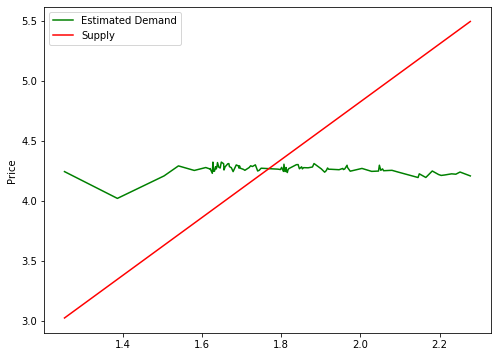

In [21]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
plt.figure()
plt.plot(Curve['num_providers'],Curve['Estimated_Demand'],color='green', label='Estimated Demand')
plt.plot(Curve['num_providers'],Curve['Supply'],color='red', label='Supply')
plt.ylabel('Price')
plt.legend(loc='best')

The price of broadband has relatively less sensitivity to demand than supply. Given the current situation, the regression result indicates the optimal number of providers are near 2, which means it would be better for both customers to have choice and providers to gain more market share. the price ranges from exp(4.25)-1 to exp(4.5)-1, which is approximately [69.1, 89] per line per month.